
# Amazon find food reviews:

Data consists of 500,000 reviews from Amazon fine food starting Oct. 1999 to Oct. 2012

source https://snap.stanford.edu/data/web-FineFoods.html

- Are reviews from top food reviewers more helpful and receive more positive feedback from the community?
- Is there any trend in review score from 1999 to 2012?
- Is it possible to predict the sentiment of the review (positive/negative) using natural language processing?
- Is it possible to visualize any structure in the word collections in lower dimensions?

# Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

# Reading the data

Data has 500,000 rows and 10 columns, including productId, userId, review helpfulness score, score, timestamp (unix timestamp) and the review itself in one or multiple sentences.

- Id: Index of user in the system
- ProductId: Unique code associated with each product
- UserId: Unique code associated with each user
- HelpfulnessNumerator: number of uers finding review helpful
- HelpfulnessDenominator: number of users checking the review
- Time: Unix stamp of review
- Summary: title of the review
- Text: review text

In [6]:
amz_review=pd.read_csv('./amazon-fine-food-reviews/Reviews.csv')

In [7]:
amz_review.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [8]:
amz_review.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# A sample review

In [9]:
amz_review['Text'][4]

'Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.'

In [10]:
amz_review['Summary'][4]

'Great taffy'

# Basic statistics on product and user number

In [11]:
print('Number of unique products:', len(amz_review['ProductId'].unique()))

Number of unique products: 74258


In [12]:
print('Number of unique users:', len(amz_review['UserId'].unique()))

Number of unique users: 256059


In [13]:
print('Estimate of number unique reviews:', len(amz_review['Text'].unique()))

Estimate of number unique reviews: 393579


In [14]:
len(amz_review['Summary'].unique())

295744

# Data pre-processing

# Check for repeated entries

A look at the data reveal that there are over 5800 entries that are repeated. Some Users simply edited their comments and the record is kept multiple time. This repetition needs to be cleaned.

In [15]:
# grouping the data by user and product to check for repeatability
amz_review.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False).head(5)

Id  ProfileName  HelpfulnessNumerator  \
UserId         ProductId                                           
A29JUMRL1US6YP B000WFKWDI  11           11                    11   
               B000WFU8O6  11           11                    11   
               B000WFN0VO  11           11                    11   
               B000WFORH0  11           11                    11   
               B000WFKI82  11           11                    11   

                           HelpfulnessDenominator  Score  Time  Summary  Text  
UserId         ProductId                                                       
A29JUMRL1US6YP B000WFKWDI                      11     11    11       11    11  
               B000WFU8O6                      11     11    11       11    11  
               B000WFN0VO                      11     11    11       11    11  
               B000WFORH0                      11     11    11       11    11  
               B000WFKI82                      11     11    11       11    11

In [16]:
# number of total repetition in data
((amz_review.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False)>1)==True).sum()

Id                        5859
ProfileName               5859
HelpfulnessNumerator      5859
HelpfulnessDenominator    5859
Score                     5859
Time                      5859
Summary                   5859
Text                      5859
dtype: int64

In [17]:
print('Initial size')
amz_review.shape

Initial size


(568454, 10)

In [18]:
# droppping duplicate only keeping one per case
amz_review_sorted_drop_duplicated=amz_review.drop_duplicates(subset=['UserId','ProductId'], keep='first', inplace=False)

In [19]:
# repeated offenders removed
((amz_review_sorted_drop_duplicated.groupby(by=['UserId','ProductId']).count().sort_values(by=['Text'],ascending=False)>1)==True).sum()

Id                        0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [20]:
print('Size after removing duplicate review')
amz_review_sorted_drop_duplicated.shape

Size after removing duplicate review


(560804, 10)

# Converting the Unix time to actual time

In [21]:
# converting unix time to year/month/day format, hour/min/sec is not available
amz_review_sorted_drop_duplicated['Time_converted']=amz_review_sorted_drop_duplicated['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))
#strftime('%Y-%m-%d %H:%M:%S'))
amz_review_sorted_drop_duplicated['Time_converted_ym']=amz_review_sorted_drop_duplicated['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
print('Earliest review')
amz_review_sorted_drop_duplicated['Time_converted'].min()

Earliest review


'1999-10-08'

In [23]:
print('latest review')
amz_review_sorted_drop_duplicated['Time_converted'].max()

latest review


'2012-10-26'

# Cleaning the text of reviews (multiple steps)

- Removing partially scraped containing html headers, and lower case the text
- Remove special characters (e.g. "{$1?&") from the text
- Removing extra space, parsing the data
- Removing stopwords (e.g. " he, she, is, the,..."), keep reviews with at least 3 word
- Removing NaN (very few)

## Removing partially scraped html from data

In [24]:
def clean_span(col):  
    
    ''' This function clean the partially scraped html data "<span" from each input after lower case conversion
    
    Input:
    
    col: text from cell of a dataframe
    
    Return:
    
    clean (no "<span") /lower case text
    '''
    
    
    if('<span' not in col.lower()):

        return col.lower()

In [25]:
amz_review_sorted_drop_duplicated['Text_new']=amz_review_sorted_drop_duplicated['Text'].apply(clean_span)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
amz_review_sorted_drop_duplicated.isnull().sum()

Id                          0
ProductId                   0
UserId                      0
ProfileName                16
HelpfulnessNumerator        0
HelpfulnessDenominator      0
Score                       0
Time                        0
Summary                    26
Text                        0
Time_converted              0
Time_converted_ym           0
Text_new                  373
dtype: int64

## Removing NaNs

In [27]:
# data is removed from very few NaNs
amz_review_sorted_drop_duplicated.dropna(inplace=True)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Removing English stop words and special characters from reviews

In [34]:
stop_word_list =[]
for word in open('./amazon-fine-food-reviews/stopword_short_long_mod.txt'):
    stop_word_list.append(word.replace('\n',''))
    
stop_word_list=list(set(stop_word_list))   
print('stop word length', len(stop_word_list))

special_char_list=['\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']

         
                
def remove_specialchar(col):
    
    ''' This function remove special characters "#, %, 1,&,.", and extra space which have no particular effect of sentiment
    analysis, 
    
    Input:
    
    col: text (string)
    
    Return:
    
    clean text without special character and extra spce
    '''    
        
    for word in special_char_list:

        if word in col: 
            col=col.replace(word,"").replace("  "," ")


    return col                  
    
def remove_stopword(col):

    ''' This function remove stopwords "he, she, is, that, the" which have no particular effect of sentiment
    analysis, parse the data, remove "\n", and keep reviews with more than 3 words
    
    Input:
    
    col: text from cell of a dataframe
    
    Return:
    
    list of parsed words from each review
    '''
    
        
    col_list=[]
    txt_col_split=col.lower().replace('\n'," ").strip().split(" ")

    for word_ in txt_col_split:

        if ((word_ not in stop_word_list) and len(word)>3):

            col_list.append(word_)

    return (col_list)

stop word length 642


In [35]:
# applying special character removal to dataframe
amz_review_sorted_drop_duplicated['Text_new2']=amz_review_sorted_drop_duplicated['Text_new'].apply(remove_specialchar)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:

# applying stop words removal to dataframe
amz_review_sorted_drop_duplicated['Text_new2']=amz_review_sorted_drop_duplicated['Text_new2'].apply(remove_stopword)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Example of parsed and cleaned review

In [37]:
#  A list of cleans words is the output
print(amz_review_sorted_drop_duplicated['Text_new2'][0])

['bought', 'vitality', 'canned', 'dog', 'food', 'products', 'good', 'quality', 'product', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


## Calculating review lenghts¶

- Length of review is calculated (after cleaning) to understand impact of more in depth content on its helpfulness
- Reviews on average have about 80 words, very small <1% go beyond 400 words

In [38]:
# lenght of review calculated stored in new column
amz_review_sorted_drop_duplicated['Text_lenght']=amz_review_sorted_drop_duplicated['Text'].apply(lambda col: len(col.split(' ')))

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


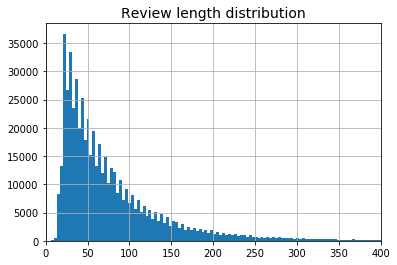

In [39]:
amz_review_sorted_drop_duplicated['Text_lenght'].hist(bins=1000);
plt.xlim(0,400)
plt.title('Review length distribution',fontsize=14);

In [40]:
amz_review_sorted_drop_duplicated['Text_lenght'].describe()

count    560389.000000
mean         81.332076
std          79.101063
min           3.000000
25%          34.000000
50%          57.000000
75%          99.000000
max        3526.000000
Name: Text_lenght, dtype: float64

In [41]:
# data checked again, no Nan observed
amz_review_sorted_drop_duplicated.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Time_converted            0
Time_converted_ym         0
Text_new                  0
Text_new2                 0
Text_lenght               0
dtype: int64

## A look at the review scores¶

- Checking the count of the reviews for each score
- Ratio of reviews with score 5 are disproportional to the rest of reviews, with 3 to 1 ratio
- This high count of "5" star reviews will be revisited again with trend with time is addressed in later section

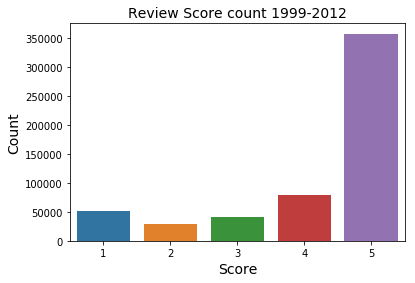

In [42]:
# plotting count of each review star
sns.countplot(x='Score', data=amz_review_sorted_drop_duplicated);
plt.xlabel('Score',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review Score count 1999-2012',fontsize=14);
plt.savefig('review_score_count_1999_2012.png')

In [43]:
def score_pos_neg(col):
    
    ''' This function get the score between 1 to five and return 1 for score>3 and return 0 for score<3,
    as positive and negative respectively
    
    Input:
    
    col: number between 1 to 5 (review star)
    
    Return:
    
    return 1 or 0
    '''
    
    if col>3:
        return 1
    else:
        return 0

amz_review_sorted_drop_duplicated['score_pos_neg']=amz_review_sorted_drop_duplicated['Score'].apply(score_pos_neg)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


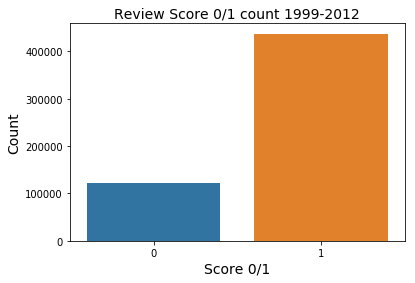

In [44]:
#plotting count of positive "1" and negative "0" reviews
sns.countplot(x='score_pos_neg', data=amz_review_sorted_drop_duplicated);
plt.xlabel('Score 0/1',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review Score 0/1 count 1999-2012',fontsize=14);
plt.savefig('review_score_01count_1999_2012.png')

In [45]:
# parsed and cleaned data is saved in csv file
amz_review_sorted_drop_duplicated.to_csv('amazon_review_parsed.csv',index=False)

## A look at top reviewer population (individuals with more than 10 reviews)

- Top reviewer are group of users to have spent more time reviewing the products and expected to have more engagement with the community, impact of this engagement effectiveness is studied in terms of feedback they receive from the community fortheir review
- Individual with more than 10 review are in top review group, regardless of number of products
- Total review count per each user is analyzed against their average review helpfulness,as well as average review length

In [73]:
# total review per user is grouped
user_number_review=amz_review_sorted_drop_duplicated.groupby(by=['UserId']).count().sort_values(by=['Text'],ascending=False)
user_number_review.reset_index(drop=False, inplace=True)
user_number_review.head()

,UserId,Id,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_converted,Time_converted_ym,Text_new,Text_new2,Text_lenght,score_pos_neg
0,A3OXHLG6DIBRW8,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419
1,AY12DBB0U420B,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382
2,A281NPSIMI1C2R,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321
3,A1YUL9PCJR3JTY,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308
4,A1Z54EM24Y40LL,251,251,251,251,251,251,251,251,251,251,251,251,251,251,251


In [82]:
# only individual with moe than 10 review incuded in top group
user_top_reviewer=user_number_review[user_number_review['Id']>10][['Id', 'UserId']]
user_top_reviewer.head(10)   #11 to 419

,Id,UserId
0,419,A3OXHLG6DIBRW8
1,382,AY12DBB0U420B
2,321,A281NPSIMI1C2R
3,308,A1YUL9PCJR3JTY
4,251,A1Z54EM24Y40LL
5,201,A2MUGFV2TDQ47K
6,167,AQQLWCMRNDFGI
7,167,AZV26LP92E6WU
8,157,A1UQBFCERIP7VJ
9,151,AY1EF0GOH80EK


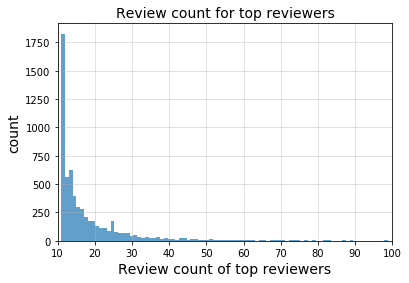

In [83]:
# distribution of review count per user

user_top_reviewer['Id'].hist(bins=400,label='Number of reviews for Top (>10) reviewer',alpha=0.7);
plt.xlabel('Review count of top reviewers',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.xlim(10,100)
plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('review_count__top_reviewer_dist.png')

In [84]:
user_top_reviewer['Id'].describe()

count    6098.000000
mean       19.741391
std        17.374368
min        11.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       419.000000
Name: Id, dtype: float64

In [85]:
user_top_reviewer.to_csv('amazon_top_reviewer_list.csv')

In [86]:
# getting average data per user
user_average_info=amz_review_sorted_drop_duplicated.groupby(by=['UserId']).mean()

In [92]:
user_average_info.reset_index(drop=False, inplace=True)

In [93]:
user_average_info.to_csv('amazon_reviewer_avg_info.csv')

On average top reviewers write about 20 reviews, with very few <1% write over 40 review

## Getting the average statistics for top reviewers

In [94]:
# merging total review count and avg data per user
top_reviewer_avg_data=pd.merge(user_average_info,user_top_reviewer,how='inner',on='UserId')

In [95]:
user_top_reviewer.head()

,Id,UserId
0,419,A3OXHLG6DIBRW8
1,382,AY12DBB0U420B
2,321,A281NPSIMI1C2R
3,308,A1YUL9PCJR3JTY
4,251,A1Z54EM24Y40LL


In [100]:
user_average_info.head()

,UserId,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg
0,#oc-R103C0QSV1DF5E,136323.0,1.0,2.0,5.0,1.343088e+09,56.0,1.0
1,#oc-R109MU5OBBZ59U,516062.0,0.0,1.0,5.0,1.350086e+09,21.0,1.0
2,#oc-R10LFEMQEW6QGZ,516079.0,0.0,1.0,5.0,1.345939e+09,85.0,1.0
3,#oc-R10LT57ZGIB140,378693.0,0.0,0.0,3.0,1.310602e+09,45.0,0.0
4,#oc-R10UA029WVWIUI,136545.0,0.0,0.0,1.0,1.342483e+09,66.0,0.0


In [101]:
top_reviewer_avg_data.head()

,UserId,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Id_y
0,A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,0.400000,55
1,A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,0.346154,26
2,A102LH0KD8SYHX,291680.428571,0.642857,0.642857,4.428571,1.272629e+09,27.214286,0.714286,14
3,A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,0.909091,11
4,A103U3KR4L2ZXT,240098.909091,0.272727,0.272727,5.000000,1.330654e+09,32.545455,1.000000,11


In [102]:
# calculate rtio of helpfulness, average number of people finding review helpful over total count commented on review
top_reviewer_avg_data['ratio_helpful']=top_reviewer_avg_data['HelpfulnessNumerator']/top_reviewer_avg_data['HelpfulnessDenominator']

In [103]:
top_reviewer_avg_data['Time_converted']=top_reviewer_avg_data['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

In [104]:
#making sure ratio of helpfulness between 0-1

top_reviewer_avg_data=top_reviewer_avg_data[(top_reviewer_avg_data['ratio_helpful']>0.0) & (top_reviewer_avg_data['ratio_helpful']<1.0)]

In [105]:
colors = np.random.rand(top_reviewer_avg_data.shape[0])

In [106]:
top_reviewer_avg_data.head()

,UserId,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Id_y,ratio_helpful,Time_converted
0,A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,0.400000,55,0.345865,2011-09
1,A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,0.346154,26,0.209302,2012-06
3,A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,0.909091,11,0.666667,2009-05
6,A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,159.666667,0.444444,18,0.200000,2010-10
8,A106Q1A6LGU4DP,225461.307692,2.615385,2.846154,4.307692,1.322106e+09,149.538462,0.769231,13,0.918919,2011-11


## Review helpfulness distribution for top reviewers

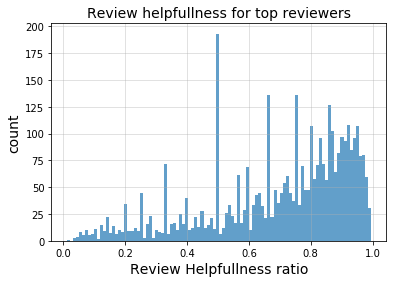

In [107]:
# review helpfulness distribution
top_reviewer_avg_data['ratio_helpful'].hist(bins=100,label='review helpfullness top reviewers',alpha=0.7);

plt.xlabel('Review Helpfullness ratio',fontsize=14);
plt.ylabel('count',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review helpfullness for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_dist.png')

## Review helpfulness vs. review length for top reviewers

In [109]:
top_reviewer_avg_data.head()

,UserId,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Id_y,ratio_helpful,Time_converted
0,A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,0.400000,55,0.345865,2011-09
1,A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,0.346154,26,0.209302,2012-06
3,A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,0.909091,11,0.666667,2009-05
6,A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,159.666667,0.444444,18,0.200000,2010-10
8,A106Q1A6LGU4DP,225461.307692,2.615385,2.846154,4.307692,1.322106e+09,149.538462,0.769231,13,0.918919,2011-11


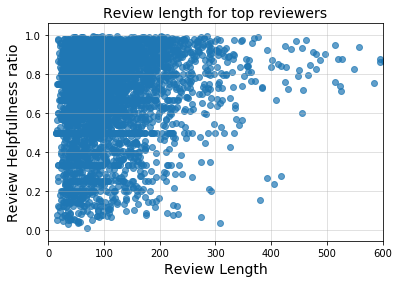

In [110]:
# review length vs helpfulness
plt.scatter(top_reviewer_avg_data['Text_lenght'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,600);
plt.xlabel('Review Length',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);
#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review length for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length.png')

Users generally find top reviewer with more than 200 words length review helpful, longer review better feedback

## Review helpfulness vs. review count for top reviewers

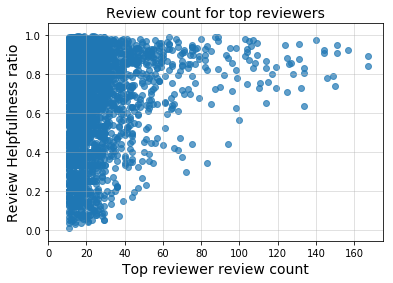

In [111]:
#review helpfulness vs. review count
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,175);
plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('helpfullness_top_reviewer_count.png')

Interestingly the top reviewers that write more often do not write very long paragraphs above 200 words, while those that write longer have less than 20-30 review

## Review score/length/helfulness trend in time

- Here the impact of time on review score, length, and helpfulness is studied
- Data are grouped by score, as well as total count per month of each year from 1999 to 2012

In [112]:
# Divide the data by score and group for each month
grp_s1=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==1]
grp_s2=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==2]
grp_s3=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==3]
grp_s4=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==4]
grp_s5=amz_review_sorted_drop_duplicated[amz_review_sorted_drop_duplicated['Score']==5]

grp_date_1=grp_s1.groupby(by=['Time_converted_ym']).count();
grp_date_2=grp_s2.groupby(by=['Time_converted_ym']).count();
grp_date_3=grp_s3.groupby(by=['Time_converted_ym']).count();
grp_date_4=grp_s4.groupby(by=['Time_converted_ym']).count();
grp_date_5=grp_s5.groupby(by=['Time_converted_ym']).count();

grp_date_1.reset_index(inplace=True); #to make it to column
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

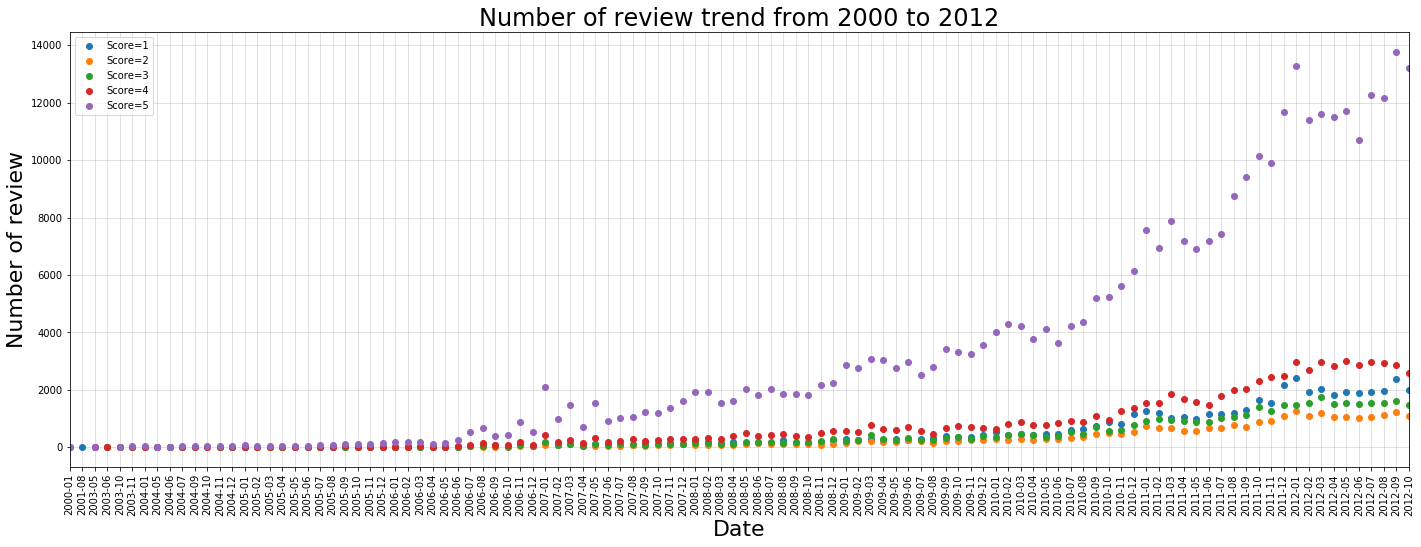

In [113]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(24,8))

plt.plot_date(x=grp_date_1['Time_converted_ym'],y=grp_date_1['Score'],label='Score=1');
plt.plot_date(x=grp_date_2['Time_converted_ym'],y=grp_date_2['Score'],label='Score=2');
plt.plot_date(x=grp_date_3['Time_converted_ym'],y=grp_date_3['Score'],label='Score=3');
plt.plot_date(x=grp_date_4['Time_converted_ym'],y=grp_date_4['Score'],label='Score=4');
plt.plot_date(x=grp_date_5['Time_converted_ym'],y=grp_date_5['Score'],label='Score=5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_trend.png')
#grp_date

- From the 2000 to 2006 there is limited review available on Amazon, however trend start to change suddenly after 2006, the total number of 5 star review show biggest surge among other scores, this seems a bit unusual and one might ask people generally are optimistic or most possibly there are unverified accounts that are boosting the seller inappropriately with fake reviews
- Another interesting observation even though minimal, during January 2007,2008,2011 and 2012 slight increase in 5 start reviews are observed. Question is this slight increase due to cheerful holiday spirit?!
- The 1 to 4 star review count gradual increase make more sense due to more customer become aware of Amazon services.

In [114]:
# average of helpfulness per month is calculated
grp_avg_date=amz_review_sorted_drop_duplicated.groupby(by=['Time_converted_ym']).mean()
grp_avg_date.reset_index(inplace=True);
grp_avg_date['Helpfulness_ratio']=grp_avg_date['HelpfulnessNumerator']/grp_avg_date['HelpfulnessDenominator']

In [115]:
grp_avg_date.head()

,Time_converted_ym,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,score_pos_neg,Helpfulness_ratio
0,1999-10,150512.500000,1.000,1.000,5.0,940075200.0,81.50,1.000,1.000000
1,1999-12,377094.500000,0.750,1.500,5.0,944352000.0,35.75,1.000,0.500000
2,2000-01,330241.500000,7.875,9.375,3.5,947797200.0,51.00,0.625,0.840000
3,2000-02,352267.666667,2.000,3.000,4.0,951523200.0,244.00,1.000,0.666667
4,2000-06,211823.600000,3.400,4.800,5.0,960785280.0,42.60,1.000,0.708333


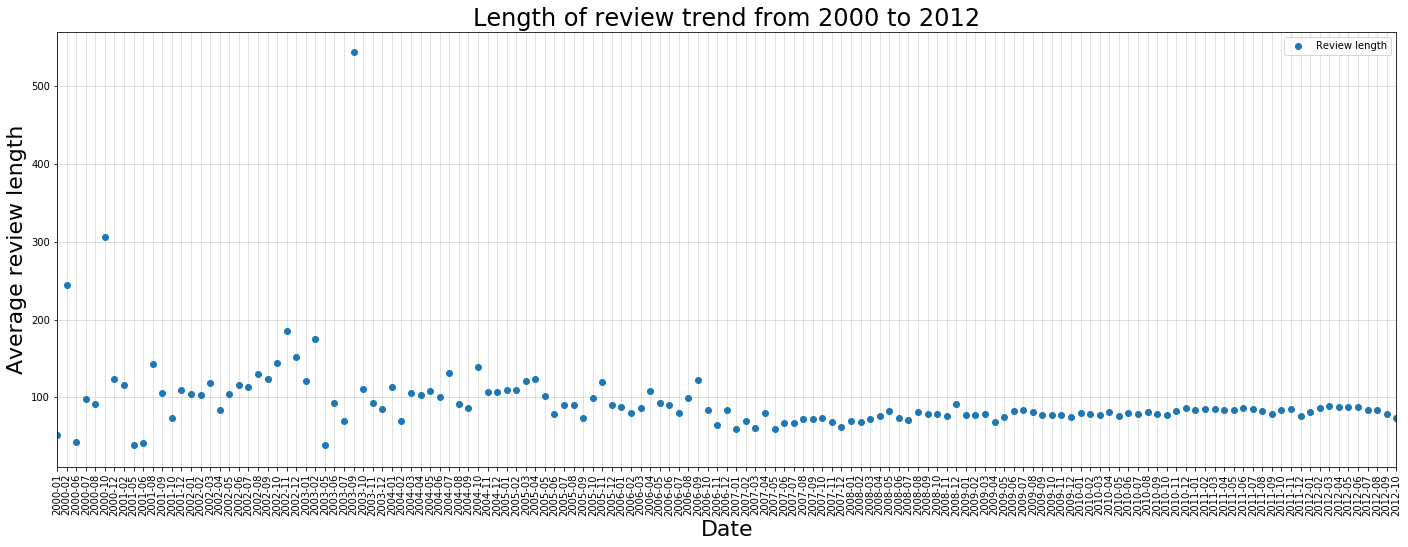

In [116]:
# average review length vs. time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_converted_ym'],y=grp_avg_date['Text_lenght'],label='Review length');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average review length',fontsize=22)
plt.title('Length of review trend from 2000 to 2012',fontsize=24);
plt.savefig('data_review_length_trend.png')
#stable review length

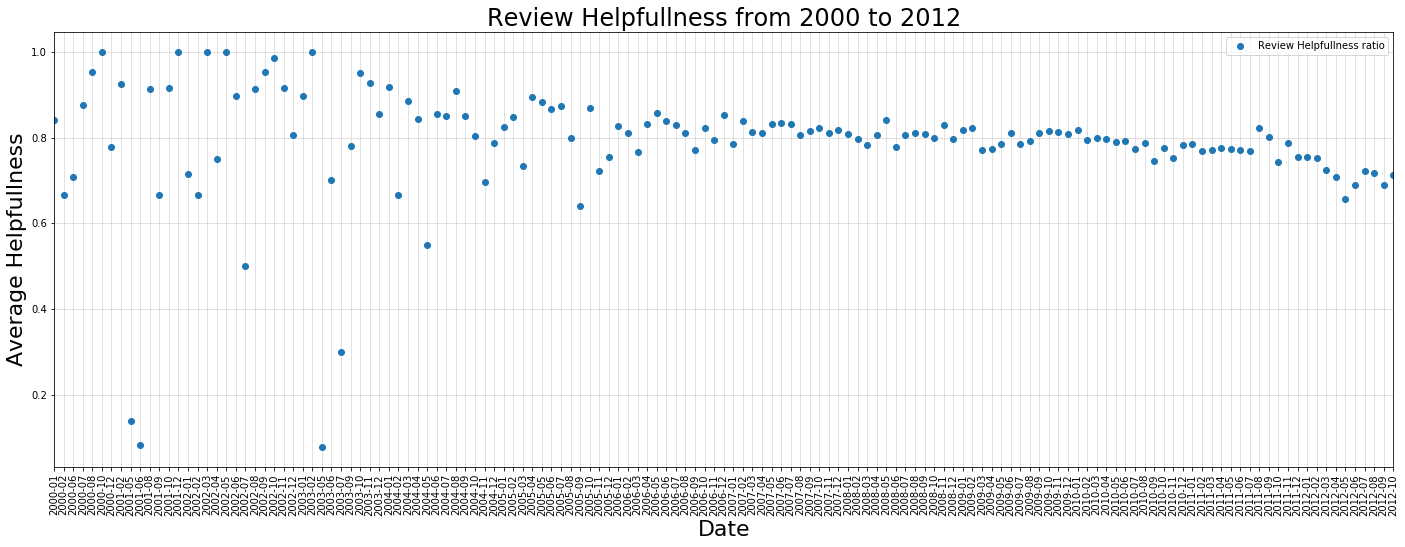

In [117]:
# review helpfulness vs time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_converted_ym'],y=grp_avg_date['Helpfulness_ratio'],label='Review Helpfullness ratio');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average Helpfullness',fontsize=22)
plt.title('Review Helpfullness from 2000 to 2012',fontsize=24);
plt.savefig('data_review_helpful_trend.png')

#drop can be due to visitor not getting time yet to check the reviews of 2012

No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed, that can be associated with the reciew itself being new and read fewer time

In [118]:
top_reviewer_avg_data.to_csv('top_reviewer_avg_data.csv',index=False)

grp_avg_date.to_csv('grp_avg_date.csv',index=False)

In [119]:
check_name=pd.read_csv('amazon_top_reviewer_list.csv')

## Dataset with fewer columns saved for sentiment analysis

In [120]:
amz_review_less_col=amz_review_sorted_drop_duplicated[['Score','Time_converted_ym', 'Text_new2', 'score_pos_neg']]

In [121]:
amz_review_less_col_rename=amz_review_less_col.rename(columns={'Text_new2':'Review_word_list'})

In [122]:
amz_review_less_col_rename.head()

,Score,Time_converted_ym,Review_word_list,score_pos_neg
0,5,2011-04,"[bought, vitality, canned, dog, food, products...",1
1,1,2012-09,"[product, arrived, labeled, jumbo, salted, pea...",0
2,4,2008-08,"[confection, centuries, light, pillowy, citrus...",1
3,2,2011-06,"[secret, ingredient, robitussin, addition, roo...",0
4,5,2012-10,"[great, taffy, great, price, wide, assortment,...",1


In [123]:
amz_review_less_col_rename.to_csv('amz_review_less_col_rename.csv',index=False)

## Sentiment Analysis

- In this section Machine learning analysis is performed on review text (now in a form of a list) and review score as positive or negative
- The first step is collecting words for all reviews, positive reviews and negative reviews separately in dictionary
- The most common words are checked in each postive and negative group
- Word polarity, which is ratio of a common word occurance in postive review vs, negative review is calculated and words with similar polarity are plotted
- Top 10000 most common words used as our vocabulry. This vocabulry is indexed to vectorized each review
- For each review first 200 words are only considered based on distribution, vectors are padded accordingly
- To account for unbalanced size of review even number of "1" and "0" review (75000) each is used)
- Data is divided into trainig/test set
- Model is trained using deep learning, with one layer of embedding, and two stack of GRU (gated recurrent unit), and one dense layer with sigmoid function

In [128]:
amz_review_less_col_rename=pd.read_csv('amz_review_less_col_rename.csv', engine='python')
amz_review_less_col_rename['Review_word_list']=amz_review_less_col_rename['Review_word_list'].apply(lambda x: eval(x))

In [129]:
amz_review_less_col_rename.head()

,Score,Time_converted_ym,Review_word_list,score_pos_neg
0,5,2011-04,"[bought, vitality, canned, dog, food, products...",1
1,1,2012-09,"[product, arrived, labeled, jumbo, salted, pea...",0
2,4,2008-08,"[confection, centuries, light, pillowy, citrus...",1
3,2,2011-06,"[secret, ingredient, robitussin, addition, roo...",0
4,5,2012-10,"[great, taffy, great, price, wide, assortment,...",1


## Creating word collector for postive/negative/all reviews

In [130]:
# initialize counters for posiive, negative and all reviews
counter_pos=Counter()
counter_neg=Counter()
counter_total=Counter()

In [131]:
# get individual review, score (0/1) and actual score 1-5 from dataframe in the vector form
review_vec=amz_review_less_col_rename['Review_word_list']
score_vec=amz_review_less_col_rename['score_pos_neg']
actual_score_vec=amz_review_less_col_rename['Score']

## A Negative review

In [132]:
# very Negative review

for i,review in enumerate(review_vec):
    
    if(i>10 and i<16 and score_vec[i]==0 and actual_score_vec[i]!=3):
        print('Negative',actual_score_vec[i],i,'\n')
        print(review)
        print(' \n')
    
    #print

Negative 1 12 

['cats', 'happily', 'eating', 'felidae', 'platinum', 'years', 'new', 'bag', 'shape', 'food', 'new', 'food', 'bowls', 'bowls', 'sit', 'full', 'kitties', 'will', 'touch', 'food', 'ive', 'noticed', 'similar', 'reviews', 'formula', 'changes', 'unfortunately', 'need', 'find', 'new', 'food', 'cats', 'will', 'eat']
 



## A positive review

In [133]:
for i,review in enumerate(review_vec):
    
    if(i>11 and i<15 and actual_score_vec[i]==5):
        print('Positive',actual_score_vec[i],i,'\n')
        print(review)
        print(' \n')

Positive 5 14 

['strawberry', 'twizzlers', 'guilty', 'pleasure', 'yummy', 'pounds', 'will', 'son']
 



## collection of words are added

In [134]:
#per postive/negative and total reviews per each review one by one

for i in tqdm(range(len(review_vec))):
    
    try:
        #print(review)
    
        for word in review_vec[i]:        
            counter_total[word] += 1

            if(score_vec[i]==1):
                counter_pos[word] += 1

            if(score_vec[i]==0):
                counter_neg[word] += 1
    except:   
        continue

A Jupyter Widget

## Most common words in negative reviews

In [135]:
# top 20 most common words in negative reviews
counter_neg.most_common()[0:20]

[('br', 70376),
 ('like', 68474),
 ('taste', 49301),
 ('product', 45142),
 ('coffee', 38648),
 ('good', 38467),
 ('flavor', 34803),
 ('will', 30477),
 ('food', 27022),
 ('tea', 25483),
 ('buy', 20925),
 ('amazon', 17527),
 ('better', 17436),
 ('again', 17404),
 ('time', 17357),
 ('box', 16800),
 ('dog', 16407),
 ('water', 15809),
 ('great', 15632),
 ('bought', 15343)]

## Most common words in positive reviews

In [136]:
# top 20 most common words in positive reviews
counter_pos.most_common()[0:20]

[('br', 191475),
 ('like', 178215),
 ('good', 153115),
 ('great', 145364),
 ('coffee', 119847),
 ('taste', 114447),
 ('love', 109636),
 ('flavor', 104099),
 ('tea', 104089),
 ('product', 99629),
 ('will', 93568),
 ('food', 89946),
 ('use', 67065),
 ('best', 66555),
 ('time', 62180),
 ('amazon', 59952),
 ('find', 59420),
 ('price', 58940),
 ('ive', 57715),
 ('well', 56124)]

## Creating collector for high polarity words (high pos/neg count)

In [137]:
# This counter only consider words ratio in postive vs negative review,
#if word not in negative collection a "1" is added to avoid NaN
# to avoidvery big or small ratio, a log value is saved

counter_pos_neg=Counter()

#words called in for over 100 times in whole reviews

for word,count in tqdm(counter_total.most_common()):
    if(count>100):
        try: 
            counter_pos_neg[word]=np.log(counter_pos[word]/float(counter_neg[word]+1))
        except:
            continue

A Jupyter Widget

## Top most polar words

- Top 40 are most positive polar appear in more postive reviews, bottom 40 polar are most negative, appear more in negative reviews

In [138]:
dict_top_pos=dict(counter_pos_neg.most_common(40))
dict_top_neg=dict(counter_pos_neg.most_common()[:-40:-1])

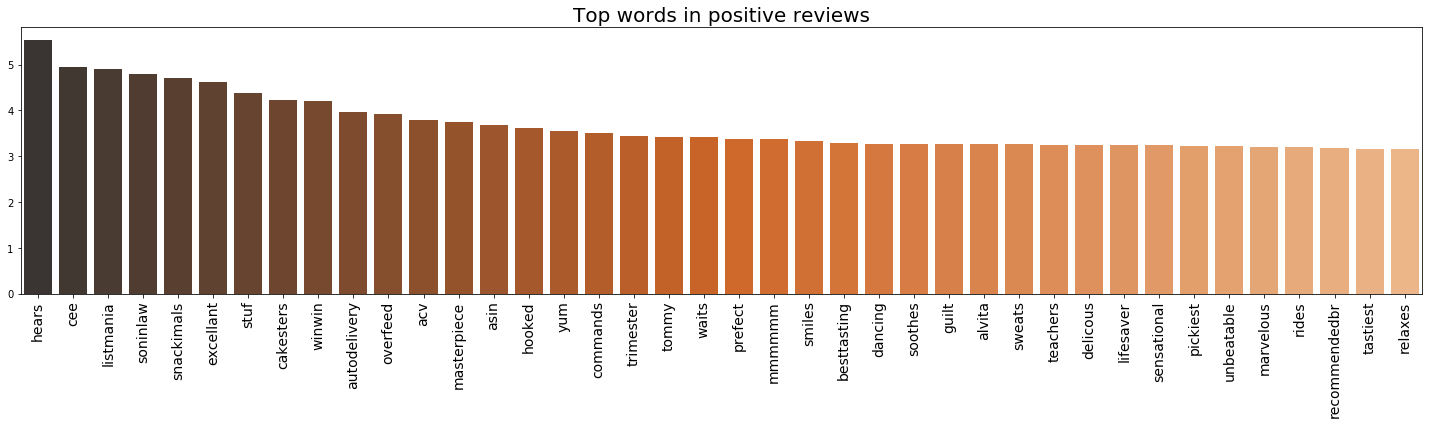

In [139]:
# Top 40 most positive polar


# plt.autolayout : True
# plt.tight_layout();
plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_pos.keys()), list(dict_top_pos.values()), palette="Oranges_d")
plt.xticks(rotation=90,fontsize=14);
plt.title('Top words in positive reviews',fontsize=20);
plt.tight_layout();
plt.savefig('word__freq_pos_rev.png')

The bundle of these polar words very much make sense, with words from "winwin", "mmmmmm", to "smile" and "relax" show postive sentiment

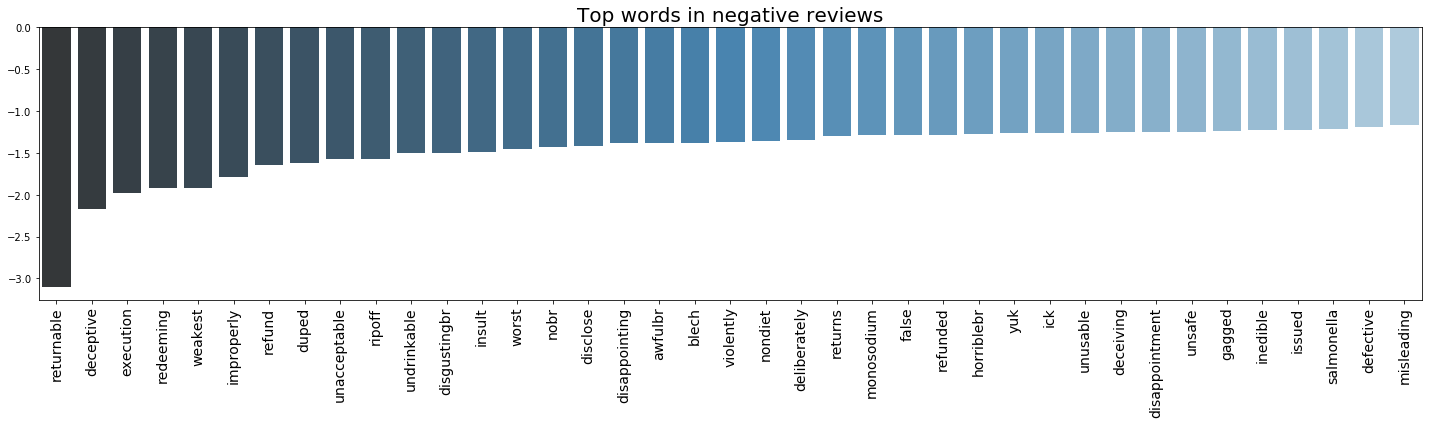

In [140]:
# Top 40 most negative polar

plt.figure(figsize=(20,6))
sns.barplot(list(dict_top_neg.keys()), list(dict_top_neg.values()), palette="Blues_d")
plt.xticks(rotation=90,fontsize=14);
plt.title('Top words in negative reviews',fontsize=20);
plt.tight_layout();
plt.savefig('word__freq_neg_rev.png')

The bundle of these polar words also make sense, with words from "returnable", "deceptive", to "ripoff" and "yuk" show more negative sentiment

Mean: 1.1207145833


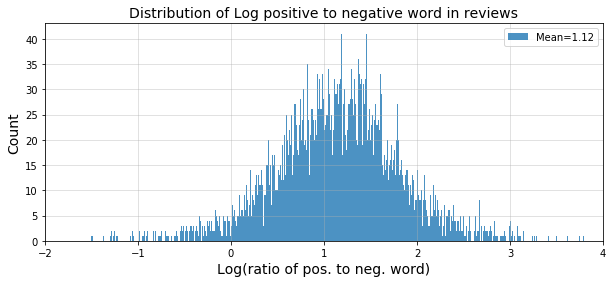

In [141]:
# polarity value distribution
print('Mean:',np.mean(list(set(counter_pos_neg.values()))))
plt.figure(figsize=(10,4));
plt.hist(counter_pos_neg.values(),bins=2000,label='Mean=1.12',alpha=0.8);
plt.xlim(-2,4)

plt.xlabel('Log(ratio of pos. to neg. word)',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Distribution of Log positive to negative word in reviews',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(loc='upper right');
plt.savefig('distribution_log_pos_neg_word_review.png')

Generally it is expected that polarity values center around one with more Gaussian distribution but due to large number of positive reviews "5' star review the center is actually shifted to 1.12. If in fact this polarity distribution need to be considered for cleaning up dictionary from neutral words (at the peak) which may jot have value to out maching leaninr work, this center shift need to be considered.

In [142]:
#dictionary count in postive, negative, ad total words
print(len(counter_pos_neg.most_common()),len(counter_pos.most_common()),len(counter_neg.most_common()),len(counter_total.most_common()))

9967 186454 92005 223134


In [143]:
print('%0.2f' %counter_pos_neg['neutral'],'%0.2f' %counter_pos_neg['diet'],'%0.2f' %counter_pos_neg['awful'],'%0.2f' %counter_pos_neg['food'])

0.86 1.26 -0.97 1.20


## Using Only top 10000 most common words as dictionary for indexing

In [144]:
# Just use top 10000 common words, these are words that show up at leadt 100 times in reviews
top_10000_common_words_dic=dict(counter_total.most_common()[0:10000])

In [145]:
top_10000_common_words_list=(list(top_10000_common_words_dic.keys()))
print(len(top_10000_common_words_list))

10000


In [146]:
#index the words based on appearance in the most common order, the order of this indexing does not matter,
# just need a rule to convert word to a number, but need to be conssitent through the study though

word_to_index={}
index_to_word={}

for i,word in enumerate(top_10000_common_words_list):
    word_to_index[word]=i
    
for word,i in word_to_index.items():
    index_to_word[i]=word

# {'br': 0, 'like': 1, 'good': 2, 'taste': 3, 'great': 4, 'coffee': 5, 'product': 6, 'flavor': 7, 'tea': 8, 'love': 9, 'will': 10, 'food': 11, 'use': 12
#{0: 'br', 1: 'like', 2: 'good', 3: 'taste', 4: 'great', 5: 'coffee', 6: 'product', 7: 'flavor', 8: 'tea', 9: 'love', 10: 'will', 11: 'food', 12:

## Word index replaces the word string for ML study

In [147]:
# making sure review is not null, and also get corresponding vectors for score, replace the words if they are in
# top 10000 list with their index

review_vec_index=[]
review_label=[]
review_score=[]

for i in tqdm(range(len(review_vec))):
    
    len_rev=len(review_vec[i])
    if(len_rev>0 and len_rev<1750):  #clean very short and very long reviews
        indices = set()
        for word in review_vec[i]:
            if word in word_to_index.keys():
                indices.add(word_to_index[word])
        review_vec_index.append(list(indices))
        review_label.append(score_vec[i])
        review_score.append(actual_score_vec[i])
                
print(len(review_vec_index),len(review_label),len(review_score))

A Jupyter Widget


560381 560381 560381


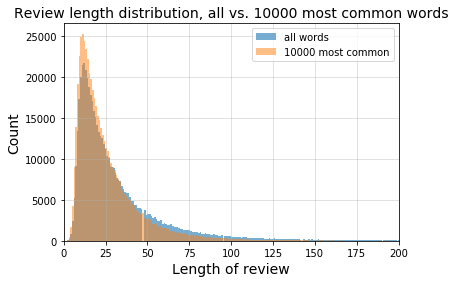

In [148]:
# length of the review before and after considerin only 10000 words
review_len_vec = pd.Series(review_vec).apply(lambda x: len(x)) 
review_len_vec_index = pd.Series(review_vec_index).apply(lambda x: len(x))

review_len_vec.hist(bins=1750,alpha=0.6,label='all words');
review_len_vec_index.hist(bins=589,alpha=0.5,label='10000 most common');
plt.xlim(0,200)
#plt.ylim(0,500)
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlabel('Length of review',fontsize=14);
plt.ylabel('Count',fontsize=14);

plt.title('Review length distribution, all vs. 10000 most common words',fontsize=14);
plt.legend()
plt.savefig('review_length_dist_before_after.png')

In [149]:
# before cosidering null review length 
review_len_vec.describe()

count    560389.000000
mean         32.635055
std          33.231570
min           0.000000
25%          14.000000
50%          23.000000
75%          39.000000
max        1714.000000
Name: Review_word_list, dtype: float64

In [150]:
#after removing null lengths and cosidering only top 10000 words
review_len_vec_index.describe()

count    560381.000000
mean         25.400021
std          20.670300
min           1.000000
25%          12.000000
50%          19.000000
75%          31.000000
max         589.000000
dtype: float64

In [151]:
print(pd.Series(review_label).describe())

count    560381.000000
mean          0.780622
std           0.413825
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
dtype: float64


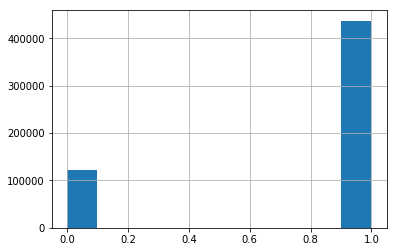

In [152]:
score_vec.hist()

## Example of index vectors

- length of each revire still varies at this stage, but need to be made consistent to 100 word vector as input of out deep learning network

In [153]:
for i,review in enumerate(review_vec_index):
    if(i<3):
        print(i,review_vec_index[i],review_label[i],review_score[i])

0 [352, 1, 2, 8259, 6, 872, 4745, 4842, 11, 77, 2235, 1421, 21, 22, 246, 283, 61, 31] 1 5
1 [1186, 964, 6, 3272, 1802, 1773, 173, 7437, 1649, 2769, 5371, 734, 63] 0 1
2 [9344, 524, 2709, 1942, 28, 1948, 160, 6694, 41, 172, 302, 303, 946, 448, 326, 2125, 80, 1491, 4439, 7384, 7517, 861, 114, 1651, 7413, 5110, 1787, 2174, 383] 1 4


In [154]:
#lists transford into array
review_score=np.array(review_score)
review_vec_index=np.array(review_vec_index)

## Using even number of postive and negative reviews for classification

- Due to uneven nature of "5" star reviews, only even number (75000) postive and negative reviews considerd
- This contain all "1", "2" star review, part of "4" and portio of "5" stars. "3" stars due to it netural content not considered

In [155]:
max_per_pos_neg=75000
counter_pos=0
counter_neg=0
review_vec_index_even=[]
review_label_even=[]
review_score_even=[]

for i in tqdm(range(len(review_score))):
    if((review_score[i]==5 or review_score[i]==4) and counter_pos<max_per_pos_neg):
        
        review_vec_index_even.append(review_vec_index[i])
        review_label_even.append(review_label[i])
        review_score_even.append(review_score[i])
        counter_pos=counter_pos+1
        
    if((review_score[i]==1 or review_score[i]==2) and counter_neg<max_per_pos_neg):
        
        review_vec_index_even.append(review_vec_index[i])
        review_label_even.append(review_label[i])
        review_score_even.append(review_score[i])
        counter_neg=counter_neg+1

A Jupyter Widget

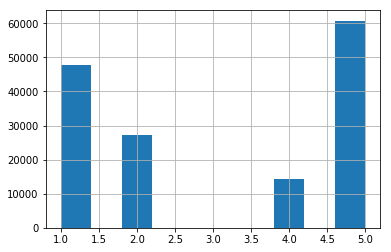

In [156]:
# reviews score after making count of positive and negative even
pd.Series(review_score_even).hist()

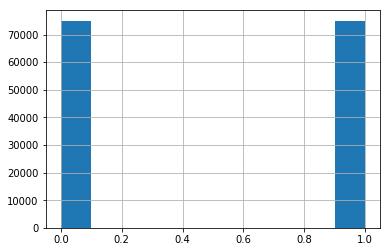

In [157]:
# reviews label after making count of positive and negative even
pd.Series(review_label_even).hist()